In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, roc_auc_score, roc_curve)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import files
uploaded = files.upload()

Saving final_dataset.csv to final_dataset.csv


In [7]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('final_dataset.csv')

In [8]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Shape: (1000, 34)

First few rows:
   UserID  Age  Gender       Location  Income   Debt  Owns Property  \
0       1   56       1       Pakistan   82812   True           True   
1       2   46       0         Mexico   27999  False           True   
2       3   32       0  United States   42436  False           True   
3       4   60       1         Barzil   62963   True          False   
4       5   25       1       Pakistan   22096  False           True   

      Profession  Demographics  Platform  ...  DeviceType       OS  \
0       Engineer             1         2  ...  Smartphone  Android   
1         Artist             0         2  ...    Computer  Android   
2       Engineer             1         4  ...      Tablet  Android   
3  Waiting staff             1         3  ...  Smartphone  Android   
4        Manager             0         1  ...  Smartphone      iOS   

   Watch Time Self Control  Addiction Level  CurrentActivity  ConnectionType  \
0     9:00 PM            5   

In [9]:
# Features and target
X = df.drop('Addiction Level', axis=1)
y = df['Addiction Level']

In [10]:
# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the training and test sets
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns after one-hot encoding - handle potential missing columns in test set
X_train_cols = X_train_encoded.columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_cols, fill_value=0)

# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [34]:
# Logistic Regression Model Builder
def create_logistic_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Dense(num_classes, activation='softmax', input_shape=(input_dim,))
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [35]:
# Function to train and evaluate with different batch sizes
def train_evaluate_model(batch_size, val_split, num_classes):
    model = create_logistic_model(X_train_scaled.shape[1], num_classes)
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_split=val_split,
        callbacks=[early_stopping],
        verbose=0
    )

    y_pred_proba = model.predict(X_test_scaled)
    y_pred = np.argmax(y_pred_proba, axis=1)


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')


    return {
        'batch_size': batch_size,
        'val_split': val_split,
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'auc': round(auc, 4)
    }

In [32]:
# Run experiments
variants = [(45, 0.02), (32, 0.4), (64, 0.2)]
results = []

num_classes = len(y.unique())

for batch_size, val_split in variants:
    metrics = train_evaluate_model(batch_size, val_split, num_classes)
    results.append(metrics)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [21]:
# Comparison Table
results_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(results_df)



Model Comparison Table:
   batch_size  val_split  accuracy  precision  recall     auc
0          45       0.02     0.800     0.8028   0.800  0.9655
1          32       0.40     0.765     0.7597   0.765  0.9557
2          64       0.20     0.785     0.7800   0.785  0.9543


In [22]:
# Best model
best_model = results_df.loc[results_df['auc'].idxmax()]
print("\nBest Model Based on AUC:")
print(best_model)


Best Model Based on AUC:
batch_size    45.0000
val_split      0.0200
accuracy       0.8000
precision      0.8028
recall         0.8000
auc            0.9655
Name: 0, dtype: float64


In [36]:
# Final model with best settings
print("\nRetraining best model with batch size:", best_model['batch_size'])
final_model = create_logistic_model(X_train_scaled.shape[1], num_classes)
final_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=int(best_model['batch_size']),
    validation_split=best_model['val_split'],
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)


Retraining best model with batch size: 45.0
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1351 - loss: 2.7093 - val_accuracy: 0.1875 - val_loss: 2.1553
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1541 - loss: 2.5167 - val_accuracy: 0.1875 - val_loss: 1.9955
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1970 - loss: 2.3448 - val_accuracy: 0.1875 - val_loss: 1.8597
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2497 - loss: 2.2016 - val_accuracy: 0.1875 - val_loss: 1.7287
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3009 - loss: 1.9914 - val_accuracy: 0.3750 - val_loss: 1.6116
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3423 - loss: 1.8785 - val_accuracy: 0.5000 - val_loss: 1.4995
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4047 - loss: 1.7246 - val_accuracy: 0.6250 - val_loss: 1.4072
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4307 - loss: 1.6291 - val_accuracy: 0.6250 - val_loss: 1.

In [37]:
# Evaluate final model
y_pred_proba = final_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        36
           1       0.60      0.75      0.67        12
           2       0.81      0.70      0.75        50
           3       0.84      0.84      0.84        32
           4       1.00      0.86      0.92         7
           5       0.79      0.91      0.85        45
           6       0.43      0.43      0.43         7
           7       0.67      0.36      0.47        11

    accuracy                           0.79       200
   macro avg       0.75      0.72      0.72       200
weighted avg       0.79      0.79      0.78       200



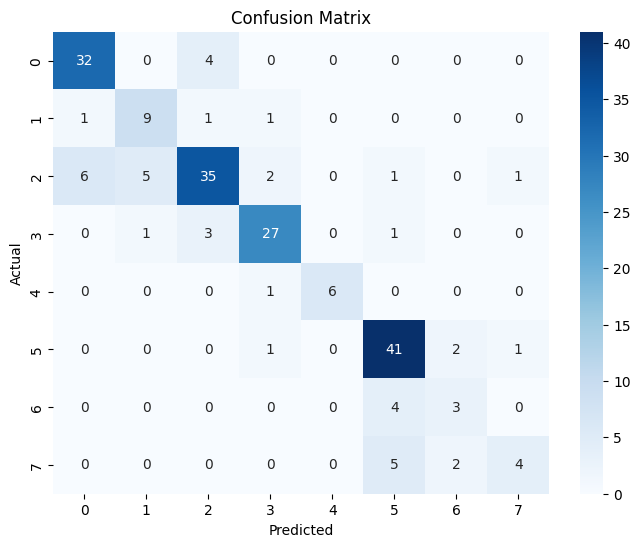

In [38]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Shape of y_pred_proba: (200, 8)


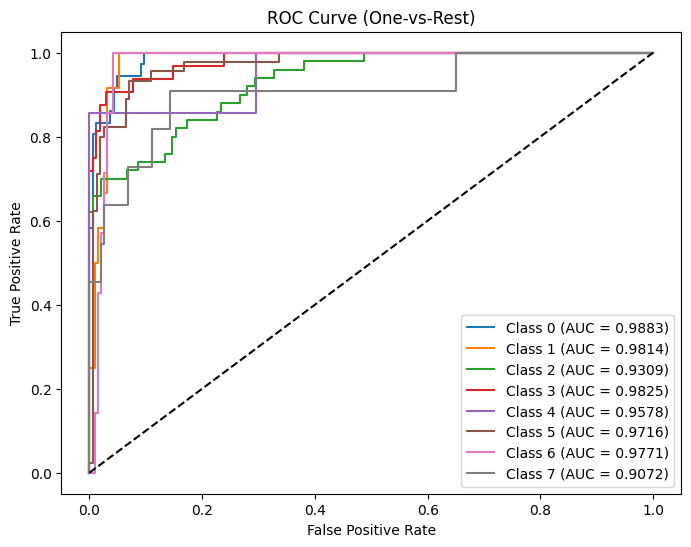

In [40]:
# ROC Curve for multiclass
plt.figure(figsize=(8, 6))
n_classes = len(y.unique())

# Calculate ROC curve and AUC for each class (One-vs-Rest)
print("Shape of y_pred_proba:", y_pred_proba.shape) # Add this line to check shape
for i in range(n_classes):
    y_test_binary = (y_test == i).astype(int)  # Binarize y_test for the current class
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binary, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()

Shape of weights: (78, 8)
Number of features in X_train_encoded: 78

Feature Importance:
                  feature  importance
19           Self Control    4.279517
18           Satisfaction    3.870515
17       ProductivityLoss    3.331348
60     Watch Time_2:00 PM    3.234341
71     Watch Time_9:00 PM    3.212815
..                    ...         ...
35     Profession_Manager    0.529160
46  Video Category_Trends    0.516948
42  Video Category_Gaming    0.508325
14    Time Spent On Video    0.479345
56               OS_MacOS    0.461898

[78 rows x 2 columns]


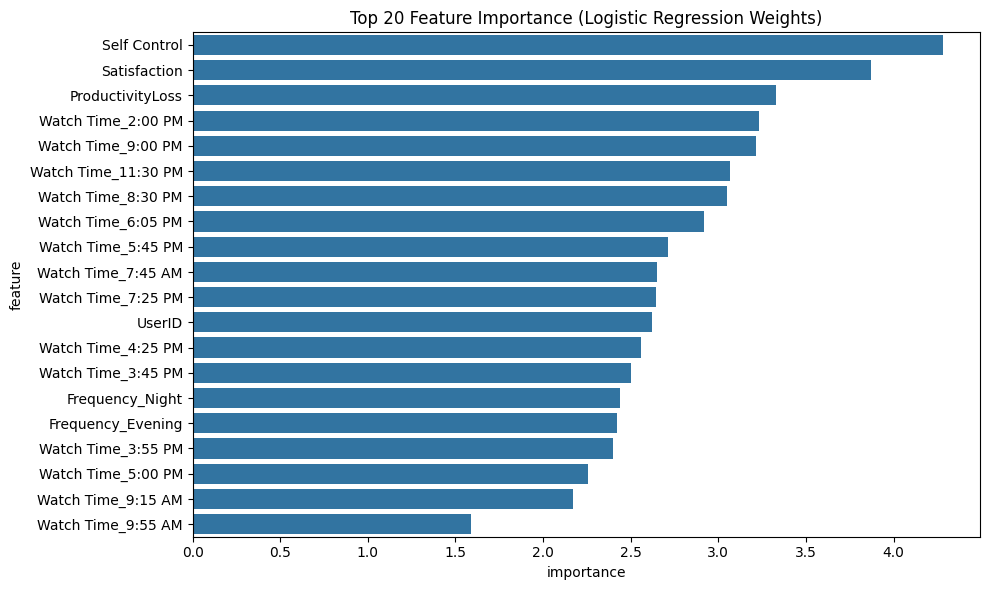

In [44]:
# Feature Importance
weights = final_model.layers[0].get_weights()[0]

print("Shape of weights:", weights.shape) # Debug print
print("Number of features in X_train_encoded:", X_train_encoded.shape[1]) # Debug print

# Calculate importance as the sum of absolute weights across all classes for each feature
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': abs(weights).sum(axis=1)  # Sum absolute weights across classes
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20)) # Display top 20 for clarity
plt.title('Top 20 Feature Importance (Logistic Regression Weights)')
plt.tight_layout()
plt.show()

In [46]:
# K-Fold Cross-Validation
print("\nPerforming 5-Fold Cross-Validation:")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

for train_idx, val_idx in kfold.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = create_logistic_model(X_tr.shape[1], num_classes)
    model.fit(X_tr, y_tr, epochs=50, batch_size=32, verbose=0)
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    fold_scores.append(acc)

print("K-Fold Accuracy Scores:", fold_scores)
print("Average K-Fold Accuracy:", np.mean(fold_scores))


Performing 5-Fold Cross-Validation:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

K-Fold Accuracy Scores: [0.7875000238418579, 0.7749999761581421, 0.78125, 0.78125, 0.831250011920929]
Average K-Fold Accuracy: 0.7912500023841857
